In [1]:
from scipy.fftpack import fft, ifft
import librosa
import numpy as np
import fnmatch
import os
import math

import matplotlib.pyplot as plt

from scipy import signal
import scipy.io.wavfile as wav
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

%matplotlib inline

In [2]:
tFrame_noise = 62.5
tFrame_filter = 30
inv = True 
dir_to_save = './filtred2'
directory_noise = "./Noise/F1/"

In [3]:
art = np.array([[[100,420],205],[[420,570],490],[[570,710],636],[[710,865],784],[[865,1030],944],[[1030,1200],1112],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205]])
tr_oct = np.array([[[180,244],200],[[244,280],250],[[280,355],315],[[355,450],400],[[450,560],500],[[560,710],630],[[710,900],800],[[900,1120],1000],[[1120,1400],1250],[[1400,1800],1600],[[1800,2240],2000],[[2240,2800],2500],[[2800,3550],3150],[[3550,4500],4000],[[4500,5600],5000],[[5600,7100],6300],[[7100,9000],8000],[[9000,1120],10000]] )
oct = np.array([[[90,175],125],[[175,355],250],[[355,710],500],[[710,1400],1000],[[1400,2800],2000],[[2800,5600],4000],[[5600,11200],8000]])

In [4]:
def read_files(directory, pattern='*.wav'):
    files = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(librosa.load(os.path.join(root, filename),8000)[0])
    return files

In [5]:
def speech_like_noise(tFrame, inv, directory = "./Noise/F1/"):
    size = np.array([i.shape[0] for i in read_files(directory)]).min()
    files_to_noise = np.sum([i[:size] for i in read_files(directory)],axis = 0)
    window_size = int(tFrame*8)
    num_windows = files_to_noise.shape[0]//window_size
    array = np.zeros((num_windows, window_size))
    for i in range(num_windows):
        array[i] = files_to_noise[i*window_size:i*window_size+window_size]
        if (inv):
            array[i] = array[i][::-1]
    num = np.arange(num_windows)
    np.random.shuffle(num)
    array = array[num]
    return np.tile(array.reshape(-1),5)
    

In [6]:
def get_A(f):
    A = []
    for _f in f[:,1]:
        if (_f>1000):
            A.append(1.37+1000/math.pow(_f,0.69))
        else:
            A.append(200/math.pow(_f,0.43)-0.37)
    return A

def get_k_math(_f):
    if (_f>400):
        return 1-1.074*math.exp(-1*math.pow(10,-4)*math.pow(_f,1.18))
    else:
        return 2.57*math.pow(10,-8)*math.pow(_f,2.4)
    
def get_k(f):
    k = []
    for _f in f[:,0]:
        k.append(get_k_math(_f[1])-get_k_math(_f[0]))
    return k

def get_Level(sig):
    return (np.sqrt(sig.dot(sig)))

def get_Q(f,spec_sig, spec_noise):
    Q = []
    A = get_A(f)
    for i,_f in enumerate(f[:,0]):
        Ls = get_Level(spec_sig[_f[0]:_f[1]+1])
        Ln = get_Level(spec_noise[_f[0]:_f[1]+1])
        q = Ls-Ln
        Q.append(q-A[i])
    return Q

def get_f(Q):
    enum = 0.78+5.46*math.exp(-1*4.3*math.pow(10,-3)*math.pow(27.3-abs(Q),2))
    if abs(Q)>1000:
        return 1e-15
    denum = 1+math.pow(10,0.1*abs(Q))
    return enum/denum

def get_p(f,spec_sig, spec_noise):
    Q = get_Q(f,spec_sig, spec_noise)
    p = []
    for q in Q:
        if (q>0):
            f = get_f(q)
            p.append(1-f)
        else:            
            p.append(get_f(q))
    return p

def get_R(p,k):
        R = 0
        for i in range(len(p)):
            R += p[i]*k[i]
        return R
    
def get_W(R):
    if (R<0):
        R=0.01
    if R<0.15:
        W=1.54*math.pow(R,0.25)*(1-math.exp(-11*R/(1+0.7*R)))
    else:
        W=1-math.exp(-11*R)
    return W

def pokrovsky(audio, noise, f):
    spec_sig = fft(audio)
    spec_noise = fft(noise)
    k = get_k(f)
    p = get_p(f,spec_sig, spec_noise)
    R = get_R(p,k)
    W = get_W(R)
    return W
      
    

In [7]:
def print_plot(sig, fs):
    widths = np.arange(1,20)
    cwtmatr=signal.cwt(sig,signal.wavelets.ricker,widths)
    sum_t = np.sum(cwtmatr,1)
    plt.figure(1,figsize =(10,8))
    gs=gridspec.GridSpec(2,3,
    width_ratios=[1,4,0.25],
    height_ratios=[1,4])
    gs.update(left=0.05 ,right=0.95 ,top=0.95, \
    bottom =0.1 , wspace =0.05 , hspace=0.05)
    #========================================================
    #ax1 = p l t . s u b p l o t ( g s [ 0 ] )
    #========================================================
    ax2 = plt.subplot(gs[1])
    ax2.plot(sig)
    plt.ylabel('Signal')
    plt.setp(ax2.get_xticklabels(),visible=False)
    plt.setp(ax2.get_yticklabels(),visible=False)
    #========================================================
    #ax3 = p l t . s u b p l o t ( g s [ 2 ] )
    #========================================================
    ax4 = plt.subplot(gs[3])
    ax4.plot(sum_t/len(sum_t),np.arange(len(sum_t)))
    plt.xlabel('Spectrum')
    plt.setp(ax4.get_xticklabels(),visible=False)
    plt.setp(ax4.get_yticklabels(),visible=False)
    #========================================================
    ax5=plt.subplot(gs[4])
    hb = ax5.imshow(cwtmatr,extent=[-1,1,1,31], \
    aspect='auto',vmax=abs(cwtmatr).max(), \
    vmin=-1*abs(cwtmatr).max())
    plt.setp(ax5.get_xticklabels(),visible=False)
    plt.setp(ax5.get_yticklabels(),visible=False)
    plt.xlabel( 'Time-Frequency Transform')
    #========================================================
    ax6=plt.subplot(gs[5])
    plt.colorbar(hb,cax=ax6)
    plt.setp(ax6.get_xticklabels(),visible=False)
    plt.setp(ax6.get_yticklabels(),visible=False)
    plt.show()

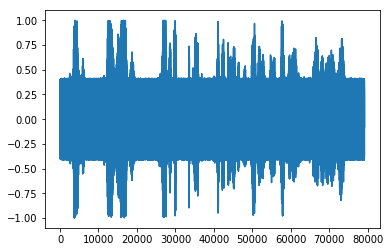

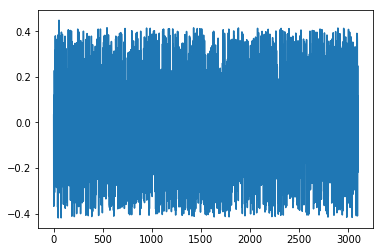

In [8]:
# 1
audio, sr = librosa.load('./Noise/Records/Rec13.wav',8000)
plt.plot(audio)
plt.show()
plt.plot(audio[30200:33300])
plt.show()

In [9]:
# 2
start = 30200
end = 33300
noise = np.tile(audio[start:end],audio.shape[0]//(end-start)+1)[:audio.shape[0]]
noise_sp = librosa.core.stft(noise,tFrame_filter*8,tFrame_filter*8)
audio_sp = librosa.core.stft(audio,tFrame_filter*8,tFrame_filter*8)
filtred_audio = librosa.core.istft(audio_sp-noise_sp,tFrame_filter*8)
if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)
librosa.output.write_wav(dir_to_save+'/self_filtred.wav',y=filtred_audio,sr=8000)

In [10]:
# 4
pokrovsky(audio,noise,oct)

0.9981106012223996

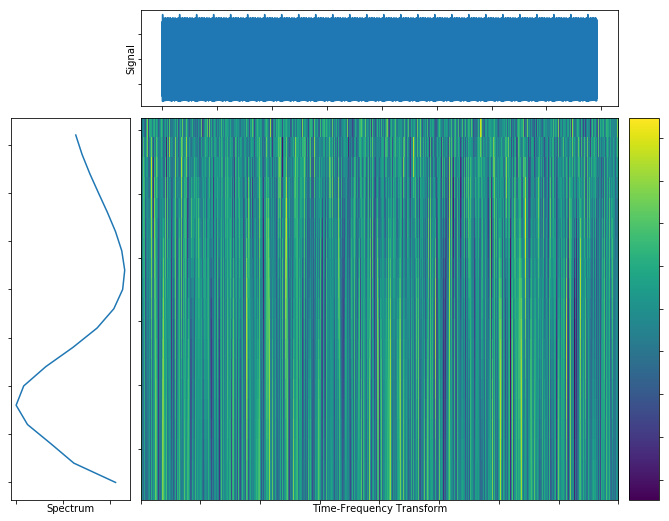

In [11]:
# 5
print_plot(noise,8000)

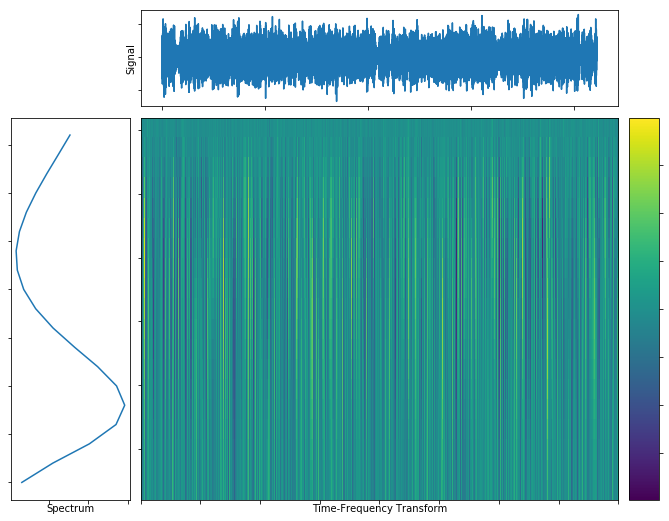

In [12]:
# 6
audio, sr = librosa.load('./Noise/F1/NoiseSpeech01_2.wav',8000)
noise = speech_like_noise(tFrame_noise, inv, directory_noise)[:audio.shape[0]]
print_plot(noise,8000)

In [23]:
# 7
#scale audio for needed db values
db = np.power(10,np.arange(-10,25,5)/20)
A_a = np.sqrt(audio.dot(audio)) 
A_n = np.sqrt(noise.dot(noise)) 
c = db*A_n/A_a
scale_audio = c.reshape(-1,1)*audio.reshape(1,-1)
scaled_noise = np.zeros((7,noise.shape[0]))
for i, _c in enumerate(c):
    scaled_noise[i] = noise / _c
#create dir and save noised and filtred audio samples
W = []
if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)
for i, _noise in enumerate(scaled_noise):
    audioANDnoise = audio + _noise
    noise_sp = librosa.core.stft(_noise,tFrame_filter*8)
    audio_sp = librosa.core.stft(audioANDnoise,tFrame_filter*8)
    filtred_audio = librosa.core.istft(audio_sp-noise_sp)
    name = '_{}db.wav'.format(str(np.arange(-10,25,5)[i]))
    librosa.output.write_wav(dir_to_save+'/filtred'+name,y=filtred_audio,sr=8000)
    librosa.output.write_wav(dir_to_save+'/audio_noised'+name,librosa.core.istft(audio_sp),8000)
    W.append(pokrovsky(audioANDnoise,_noise,oct))
    print ('Rsn =',np.arange(-10,25,5)[i],' W =', pokrovsky(audioANDnoise,_noise,oct))

Rsn = -10  W = 0.9058686101307349
Rsn = -5  W = 0.9058590133438117
Rsn = 0  W = 0.958003172724392
Rsn = 5  W = 0.9580030259238396
Rsn = 10  W = 0.9985732947101921
Rsn = 15  W = 0.9985766467454155
Rsn = 20  W = 0.9999169799161753


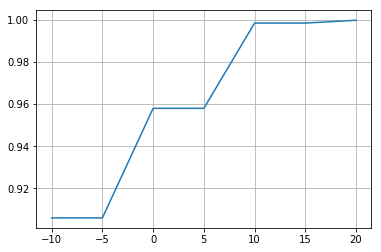

In [24]:
# 8
plt.plot(np.arange(-10,25,5),W);
plt.grid(True);

Rsn = -10  W = 0.298
Rsn = -5  W = 0.521
Rsn = 0  W = 0.659
Rsn = 5  W = 0.801
Rsn = 10  W = 0.885
Rsn = 15  W = 0.951
Rsn = 20  W = 0.988


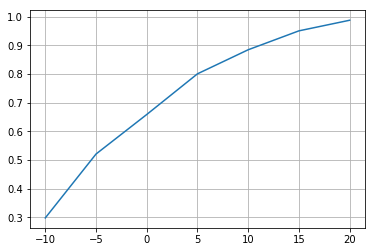

In [21]:
W = [0.298, 0.521, 0.659, 0.801, 0.885, 0.951, 0.988] 

for i, R in enumerate(np.arange(-10,25,5)): 
    print ('Rsn =',R,' W =', W[i]); 

plt.plot(np.arange(-10,25,5),W); 
plt.grid(True); 
plt.plot();

In [166]:
audio, sr = librosa.load('./Noise/F1/NoiseSpeech01_7.wav',8000)
noise = speech_like_noise(tFrame_noise, inv, directory_noise)[:audio.shape[0]]
pokrovsky(audioANDnoise, noise, oct)

0.9996289769614277

In [77]:
art = np.array([[[100,420],205],[[420,570],490],[[570,710],636],[[710,865],784],[[865,1030],944],[[1030,1200],1112],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205],[[100,420],205]])
tr_oct = np.array([[[180,244],200],[[244,280],250],[[280,355],315],[[355,450],400],[[450,560],500],[[560,710],630],[[710,900],800],[[900,1120],1000],[[1120,1400],1250],[[1400,1800],1600],[[1800,2240],2000],[[2240,2800],2500],[[2800,3550],3150],[[3550,4500],4000],[[4500,5600],5000],[[5600,7100],6300],[[7100,9000],8000],[[9000,1120],10000]] )
oct = np.array([[[90,175],125],[[175,355],250],[[355,710],500],[[710,1400],1000],[[1400,2800],2000],[[2800,5600],4000],[[5600,11200],8000]])

In [24]:
round(math.sqrt(1200*1030))

1112

In [25]:
audio, sr = librosa.load('./Noise/F1/NoiseSpeech01_7.wav',8000)
noise = speech_like_noise(tFrame_noise, inv, directory_noise)[:audio.shape[0]]

In [26]:
#scale audio for needed db values
db = np.power(10,np.arange(-10,25,5)/20)
A_a = np.sqrt(audio.dot(audio)) 
A_n = np.sqrt(noise.dot(noise)) 
c = db*A_n/A_a
scale_audio = c.reshape(-1,1)*audio.reshape(1,-1)

In [27]:
#create dir and save noised and filtred audio samples 
if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)
for i, _audio in enumerate(scale_audio):
    audioANDnoise = _audio + noise
    noise_sp = librosa.core.stft(noise,tFrame_filter*8)
    audio_sp = librosa.core.stft(audioANDnoise,tFrame_filter*8)
    filtred_audio = librosa.core.istft(audio_sp-noise_sp)
    name = '_{}db.wav'.format(str(np.arange(-10,25,5)[i]))
    librosa.output.write_wav(dir_to_save+'/filtred'+name,y=filtred_audio,sr=8000)
    librosa.output.write_wav(dir_to_save+'/audio_noised'+name,librosa.core.istft(audio_sp),8000)

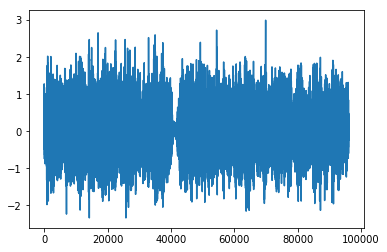

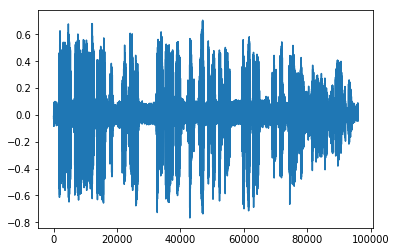

In [107]:
audioANDnoise = scale_audio[0] + noise
noise_sp = librosa.core.stft(noise,tFrame_filter*8)
audio_sp = librosa.core.stft(audioANDnoise,tFrame_filter*8)
filtred_audio = librosa.core.istft(audio_sp-noise_sp)
plt.plot(audioANDnoise)
plt.show()
plt.plot(filtred_audio)
plt.show()

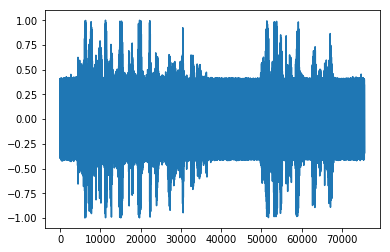

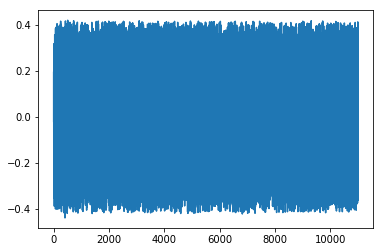

In [18]:
audio, sr = librosa.load('./Noise/Records/Rec07.wav',8000)
plt.plot(audio)
plt.show()
plt.plot(audio[37000:48000])
plt.show()

In [43]:
start = 40000
end = 42000
noise = np.tile(audio[start:end],audio.shape[0]//(end-start)+1)[:audio.shape[0]]
noise_sp = librosa.core.stft(noise,tFrame_filter*8,tFrame_filter*8)
audio_sp = librosa.core.stft(audio,tFrame_filter*8,tFrame_filter*8)
filtred_audio = librosa.core.istft(audio_sp-noise_sp,tFrame_filter*8)
if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)
# librosa.output.write_wav(dir_to_save+'/self_filtred.wav',y=filtred_audio,sr=8000)

In [44]:
filtred_audio.shape, audio.shape

((75520,), (75570,))

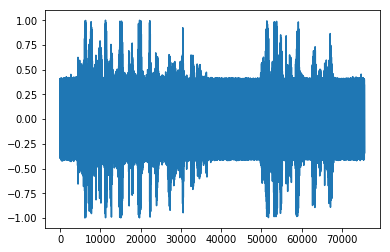

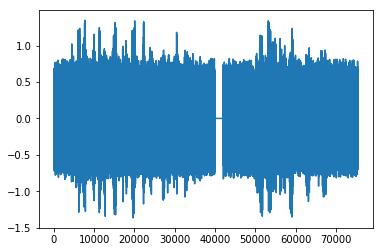

In [45]:
plt.plot(audio)
plt.show()
plt.plot(filtred_audio)
plt.show()